<a href="https://colab.research.google.com/github/smridhiwho/LSTM_Image_Classification_LIDC-IDRI/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
from tensorflow.keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

In [ ]:
#define the transformations that we want to apply
transformations = {'train' : transforms.Compose([transforms.Resize((32, 32)),
                                                 transforms.Grayscale(),
                                                 transforms.ToTensor()])}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = #path of train dataset
val_path = #path of testing dataset

In [ ]:
dataset = {'train' : datasets.ImageFolder(train_path, transform = transformations['train']),
          'valid' : datasets.ImageFolder(val_path, transform = transformations['train'])}

In [ ]:
dataset

In [ ]:
#load the dataset
data_loader = {'train' : DataLoader(dataset['train'], batch_size =16, shuffle = True),
              'valid' : DataLoader(dataset['valid'], batch_size = 16, shuffle = False)}

In [ ]:

images, labels = next(iter(data_loader['train']))

In [ ]:
images.shape

In [ ]:
#see if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(LSTM, self).__init__()
        
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        #initialize the hidden state and the cell state with zeros
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        
        out, (hidden, cell) = self.lstm(x, (h0, c0))
        
        output_ = out[:, -1, :]
        
        output = self.fc(output_)
        
        return output


In [ ]:
#instatiate the model
SEQ_LEN = 80
INPUT_DIM = 32
OUTPUT_DIM = 2
HIDDEN_DIM = 128
N_LAYERS = 2
model = LSTM(input_dim = INPUT_DIM, output_dim = OUTPUT_DIM, hidden_dim = HIDDEN_DIM, n_layers = N_LAYERS)
print(model)

In [ ]:
#define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
#define the loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
#writer = SummaryWriter('Pulmonary Nodules')

In [ ]:
if __name__ == '__main__':

  # Initialize the SummaryWriter for TensorBoard
  # Its output will be written to ./runs/
  writer = SummaryWriter()

In [ ]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

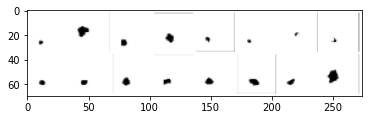

In [ ]:
# get some random training images
#dataiter = iter((data_loader['train']))
images, labels = next(iter(data_loader['train']))
#images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('Pulmonary Nodules', img_grid)

In [ ]:
#now we will TRAIN the model
def train_model(model, criterion, optimizer, num_epochs):
    loss_idx_value = 0
    acc_idx_value = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for input_, label in data_loader[phase]:
                inputs = input_.squeeze(1).to(device)
                labels = label.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                writer.add_scalar("Loss", running_loss, loss_idx_value)
                loss_idx_value += 1
                
                running_corrects += torch.sum(preds == labels.data)
                writer.add_scalar("Accuracy", running_corrects, acc_idx_value)
                acc_idx_value += 1
               

            epoch_loss = running_loss / len(dataset[phase])
            epoch_acc = running_corrects.float() / len(dataset[phase])
            
            writer.add_scalar("Accuracy per epoch", epoch_acc, epoch)
            writer.add_scalar("Loss per epoch", epoch_loss, epoch)


            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss.item(), epoch_acc.item()))
    return model

In [ ]:
model = model.to(device)

In [ ]:
training = train_model(model = model, criterion = criterion, optimizer = optimizer, num_epochs = 100)

In [ ]:
model.state_dict()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=runs

#SAVING A PYTORCH MODEL

https://colab.research.google.com/github/agungsantoso/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%206%20-%20Saving%20and%20Loading%20Models.ipynb

In [ ]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

In [ ]:
from google.colab import files
torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

In [ ]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [ ]:
model = load_checkpoint('checkpoint.pth')
print(model)